In [20]:
# Checkout www.pygimli.org for more examples


# 3D magnetics modelling and inversion

Based on the synthetic model of Li & Oldenburg (1996), we demonstrate 3D
inversion of magnetic data. The forward operator bases on the formula given by
Holstein et al. (2007).

In the following, we will build the model, create synthetic data, and do
inversion using a depth-weighting function as outlined in the paper.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling

## Synthetic model and data generation
The grid is 1x1x0.5 km with a spacing of 50 m.




In [22]:
dx = 50
x = np.arange(0., 1001, dx)
y = np.arange(0., 1001, dx)
z = np.arange(-500., .1, dx)
grid = pg.createGrid(x, y, z)
print(grid)

Mesh: Nodes: 4851 Cells: 4000 Boundaries: 12800


We create a 3D matrix that is later filled as vector into the grid. The
model consists of zeros and patches of 5x6 cells per depth slice that
are shifted by one cell for subsequent cells.




In [23]:
v = np.zeros((len(z)-1, len(y)-1, len(x)-1))
for i in range(7):
    v[1+i, 11-i:16-i, 7:13] = 0.05 # magnetization intensity

# Synthetic model 
grid["synth"] = v.ravel()

We show the model making use of the pyvista package that can be called by
`pygimli.show()`. The mesh itself is shown as a wireframe, the anomaly
is plotted as a surface plot using a threshold filter. After the first call
with ``hold=True``, the plotter is used to draw any subsequent plots that can
also be slices or clips. Moreover, the camera position is set so that the
vertical axis is going downwards (x is Northing and y is Easting as common in
magnetics).




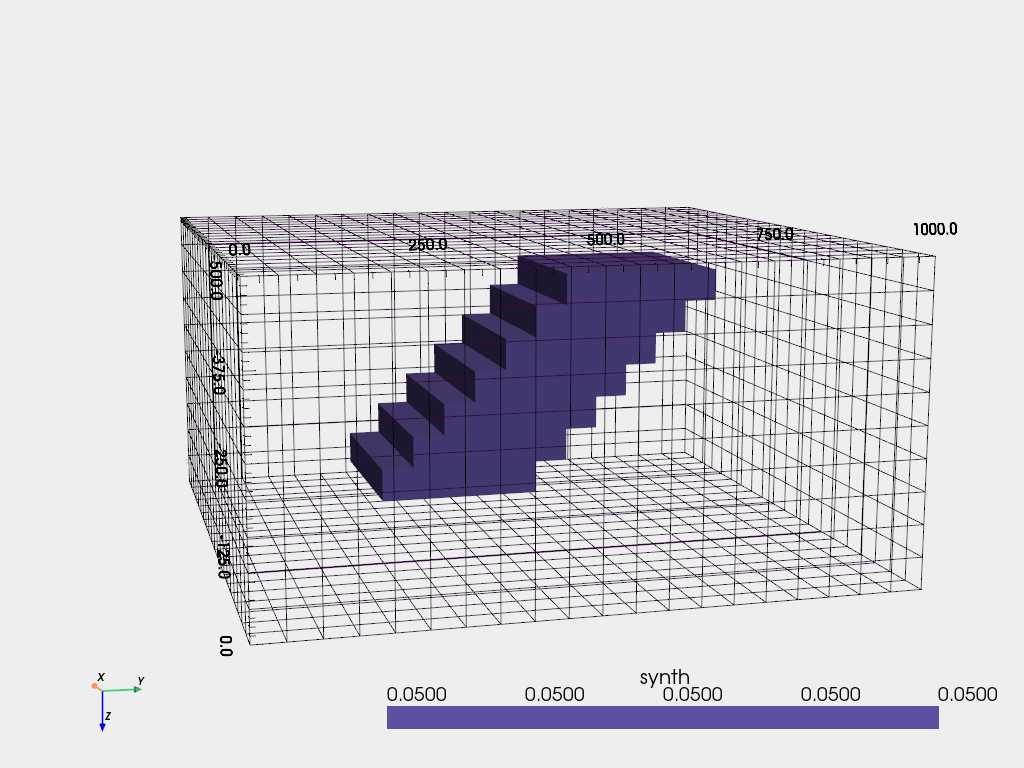

In [24]:
pl, _ = pg.show(grid, style="wireframe", hold=True)
pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180 - 15
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

For the computation of the total field, we define the global magnetic
field using the IGRF (total field, inclination and declination) settings
given in the paper. Any global field can also be retrieved by the
``pyIGRF`` module.




In [26]:
# F, I, D = 50000, 75, 25  # total field in nT
# H = F * np.cos(np.deg2rad(I))
# X = H * np.cos(np.deg2rad(D))
# Y = H * np.sin(np.deg2rad(D))
# Z = F * np.sin(np.deg2rad(I))
# igrf = [D, I, H, X, Y, Z, F]

# Alternatively one could use pyIGRF at a specific position
import pyIGRF
igrf = pyIGRF.igrf_value(lat=50.59465, lon=12.64139)
# igrf = [igrf]

py, px = np.meshgrid(x, y)
px = px.ravel()
py = py.ravel()
points = np.column_stack((px, py, np.ones_like(px)*20))
print(points)

[[   0.    0.   20.]
 [   0.   50.   20.]
 [   0.  100.   20.]
 ...
 [1000.  900.   20.]
 [1000.  950.   20.]
 [1000. 1000.   20.]]


In [31]:
# The forward operator
# Componentes del campo
cmp = ["TFA"]  # ["Bx", "By", "Bz"]
fop = MagneticsModelling(mesh=grid, points=points, cmp=cmp, igrf=igrf)
model = pg.Vector(grid.cellCount(), 1.0)
data = fop.response(grid["synth"])

No module named 'tqdm'.
You need to install this optional dependency to use nice progressbar in jupyter notebook.
[++++++++++++++++ 100% ++++++++++++++++] 441 of 441 complete


Just like in the paper, the data are contaminated with an error model
consisting of relative and absolute noise of 2% and 1 nT, respectively.




In [7]:
noise_level = 5  # nT

# Agrega ruido aleatorio a los datos
data += np.random.randn(len(data)) * noise_level

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the
constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}




In [8]:
# depth weighting
bz = np.array([abs(b.center().z()) for b in grid.boundaries() if not b.outside()])
z0 = 25
wz = 100 / (bz+z0)**1.5
print(min(wz), max(wz))

0.008944271909999158 0.282842712474619


## Inversion

The inversion is rather straightforward using the standard inversion
framework `pygimli.Inversion`.




In [49]:
inv = pg.Inversion(fop=fop, verbose=True)  # , debug=True)
inv.setRegularization(limits=[0, 0.07])  # to limit values
inv.setConstraintWeights(wz)
invmodel = inv.run(data, absoluteError=noise_level, lam=20, startModel=1e-03, verbose=True)
grid["inv"] = invmodel

01/01/24 - 13:00:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x000001C620380400>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C6203D7640>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001C6203D7E80>
min/max (data): -54.2/316
min/max (error): 1.58%/9279%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  210.37
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   49.48 (dPhi = 76.42%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    4.61 (dPhi = 90.34%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.88 (dPhi = 56.80%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.

## Visualization

For showing the model, we again use the threshold filter with a value of
0.02. For comparison with the synthetic model, we plot the latter as a
wireframe.




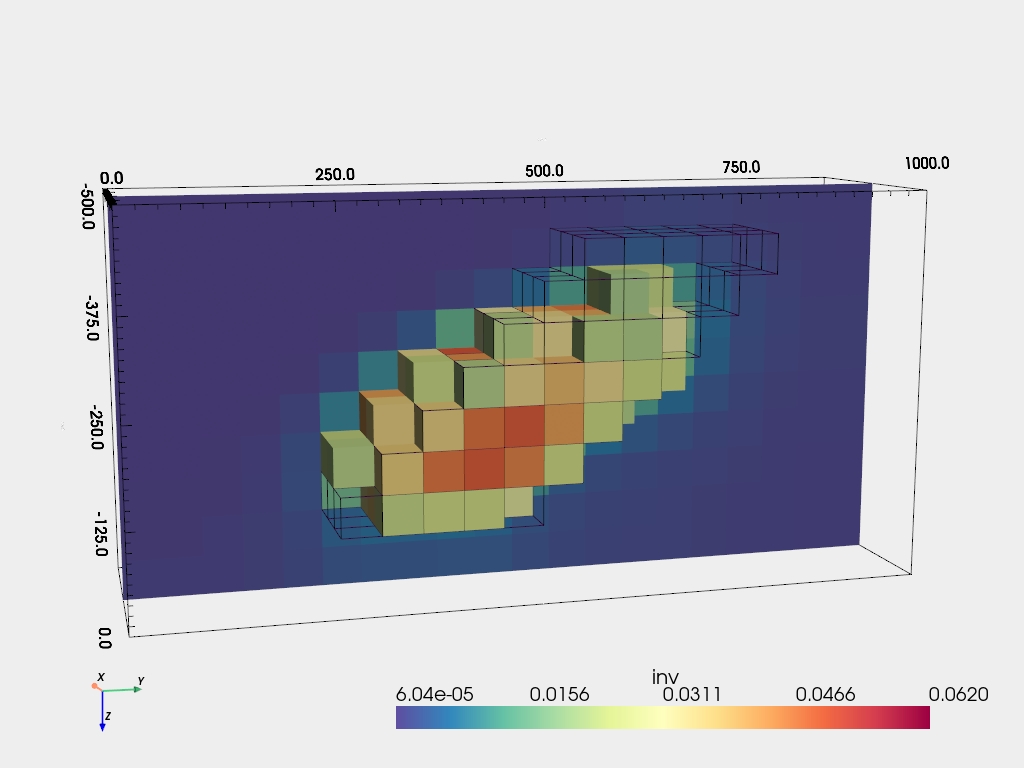

In [50]:
pl, _ = pg.show(grid, label="synth", style="wireframe", hold=True,
                filter={"threshold": dict(value=0.025, scalars="synth")})
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.02, scalars="inv")})
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"slice": dict(normal=[-1, 0, 0], origin=[500, 600, 250])})
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180 - 15
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

The model can nicely outline the top part of the anomalous body, but not
its depth extent.

We compare the data and model response by means of scatter plots:




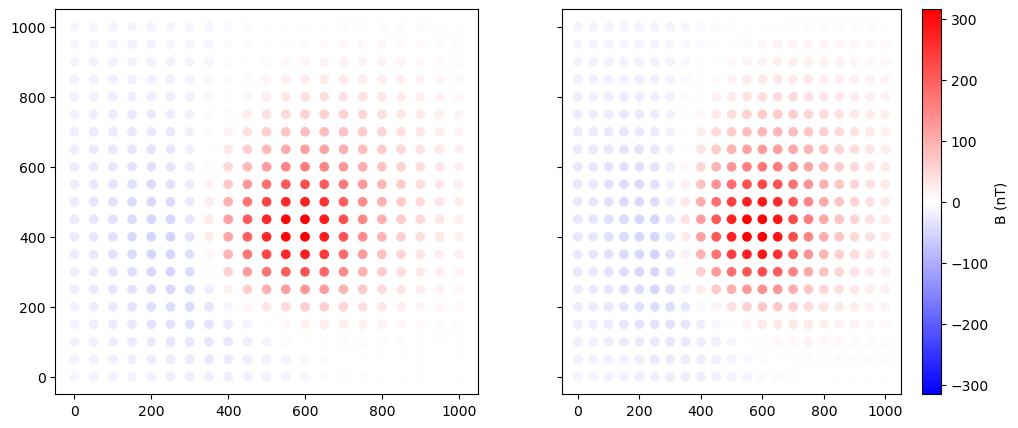

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)
vals = data
mm = np.max(np.abs(vals))
ax[0].scatter(px, py, c=vals, cmap="bwr", vmin=-mm, vmax=mm)
im = ax[1].scatter(px, py, c=inv.response, cmap="bwr", vmin=-mm, vmax=mm)
cb = plt.colorbar(im, ax=ax[1])
cb.set_label("B (nT)")

Alternatively, we can also plot the error-weighted misfit.




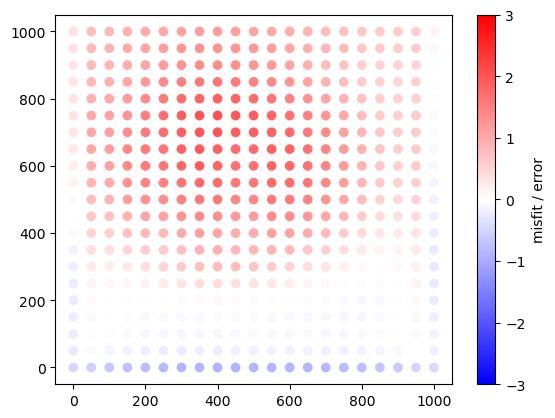

In [48]:
misfit = (inv.response - data) / noise_level
im = plt.scatter(py, px, c=misfit, cmap="bwr", vmin=-3, vmax=3)
cb = plt.colorbar(im)
cb.set_label("misfit / error")

## References

-  Li, Y. & Oldenburg, D. (1996): 3-D inversion of magnetic data.
   Geophysics 61(2), 394-408.
-  Holstein, H., Sherratt, E.M., Reid, A.B.  (2007): Gravimagnetic field
   tensor gradiometry formulas for uniform polyhedra, SEG Ext. Abstr.


